In [1]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers, models

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Data Augmentation

In [ ]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import os

data_dir = '/content/PlantVillageData/PlantVillage'
output_dir = '/content/augmented_images'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Hàm zoom cho ảnh
def zoom_image(image, zoom_factor):
    width, height = image.size
    x1 = int((1 - zoom_factor) * width / 2)
    y1 = int((1 - zoom_factor) * height / 2)
    x2 = int((1 + zoom_factor) * width / 2)
    y2 = int((1 + zoom_factor) * height / 2)
    return image.crop((x1, y1, x2, y2))

# Hàm áp dụng các phép biến đổi và lưu lại ảnh
def apply_augmentation_to_image(img_path, save_dir):
    img = Image.open(img_path)
    base_name = os.path.splitext(os.path.basename(img_path))[0]

    # Các phép biến đổi
    zoom_factor = 0.9  # 10% zoom
    img_zoom = img
    img_flip_zoom = ImageOps.mirror(img)
    img_rotate_15_zoom = zoom_image(img.rotate(15, resample=Image.BICUBIC, expand=True), zoom_factor)
    img_rotate_345_zoom = zoom_image(img.rotate(-15, resample=Image.BICUBIC, expand=True), zoom_factor)
    img_flip_rotate_15_zoom = zoom_image(ImageOps.mirror(img).rotate(15, resample=Image.BICUBIC, expand=True), zoom_factor)
    img_flip_rotate_345_zoom = zoom_image(ImageOps.mirror(img).rotate(-15, resample=Image.BICUBIC, expand=True), zoom_factor)

    # Lưu các ảnh đã biến đổi với tên file mới vào thư mục con tương ứng
    img_zoom.save(f'{save_dir}/{base_name}_zoom.jpg')
    img_flip_zoom.save(f'{save_dir}/{base_name}_flip_zoom.jpg')
    img_rotate_15_zoom.save(f'{save_dir}/{base_name}_rotate_15_zoom.jpg')
    img_rotate_345_zoom.save(f'{save_dir}/{base_name}_rotate_345_zoom.jpg')
    img_flip_rotate_15_zoom.save(f'{save_dir}/{base_name}_flip_rotate_15_zoom.jpg')
    img_flip_rotate_345_zoom.save(f'{save_dir}/{base_name}_flip_rotate_345_zoom.jpg')


for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg')):
            img_path = os.path.join(root, file)

            relative_path = os.path.relpath(root, data_dir)
            save_dir = os.path.join(output_dir, relative_path)

            if not os.path.exists(save_dir):
                os.makedirs(save_dir)

            apply_augmentation_to_image(img_path, save_dir)


In [4]:
import zipfile

# Giải nén fi;e data
zip_path = '/content/drive/MyDrive/augmented_images.zip'
extract_path = '/content/augmented_images'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [5]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 24

## Data Splitting


In [6]:
data_dir = '/content/augmented_images/content/augmented_images'

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3  # Chia 30% dữ liệu cho validation (và 70% cho training)
)

# Tạo dữ liệu cho training và test
training_image_data = image_generator.flow_from_directory(
    data_dir,
    shuffle=True,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=42
)

test_image_data = image_generator.flow_from_directory(
    data_dir,
    shuffle=True,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=42
)


Found 79107 images belonging to 10 classes.
Found 33897 images belonging to 10 classes.


In [ ]:
class_names = sorted(training_image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Tomato___Bacterial_Spot', 'Tomato___Early_Blight',
       'Tomato___Late_Blight', 'Tomato___Leaf_Mold',
       'Tomato___Septoria_Leaf_Spot',
       'Tomato___Spider_Mites Two-Spotted_Spider_Mite',
       'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
       'Tomato___Tomato_Mosaic_Virus', 'Tomato___Healthy'], dtype='<U45')

## Transfer Learning


### Mobile NetV2

In [27]:
# Tải mô hình MobileNetV2 đã huấn luyện trên ImageNet
mobilenet_base = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
mobilenet_base.trainable = False
mobilenet_base.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [28]:
# Xây dựng mô hình
mobilenet_model = models.Sequential([
    mobilenet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')
])
mobilenet_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [29]:
#Khởi tạo các siêu tham số
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,  # Learning rate
    beta_1=0.9,           # β1
    beta_2=0.999,         # β2
    epsilon=1e-7          # epsilon
)

In [30]:
# Biên dịch mô hình
mobilenet_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['acc'])

# Huấn luyện MobileNetV2
print("\nTraining MobileNetV2:")
mobilenetv2_history = mobilenet_model.fit(training_image_data,
                                        validation_data=test_image_data,
                                        epochs=10,
                                        batch_size=BATCH_SIZE)



Training MobileNetV2:
Epoch 1/10
3297/3297 ━━━━━━━━━━━━━━━━━━━━ 246s 72ms/step - acc: 0.7739 - loss: 0.6909 - val_acc: 0.8810 - val_loss: 0.3456
Epoch 2/10
3297/3297 ━━━━━━━━━━━━━━━━━━━━ 212s 64ms/step - acc: 0.8921 - loss: 0.3237 - val_acc: 0.8981 - val_loss: 0.3073
Epoch 3/10
3297/3297 ━━━━━━━━━━━━━━━━━━━━ 284s 71ms/step - acc: 0.8981 - loss: 0.2920 - val_acc: 0.9043 - val_loss: 0.2837
Epoch 4/10
3297/3297 ━━━━━━━━━━━━━━━━━━━━ 214s 65ms/step - acc: 0.9055 - loss: 0.2735 - val_acc: 0.8996 - val_loss: 0.3001
Epoch 5/10
3297/3297 ━━━━━━━━━━━━━━━━━━━━ 261s 65ms/step - acc: 0.9043 - loss: 0.2751 - val_acc: 0.9039 - val_loss: 0.2845
Epoch 6/10
3297/3297 ━━━━━━━━━━━━━━━━━━━━ 285s 72ms/step - acc: 0.9070 - loss: 0.2655 - val_acc: 0.9103 - val_loss: 0.2700
Epoch 7/10
3297/3297 ━━━━━━━━━━━━━━━━━━━━ 216s 65ms/step - acc: 0.9093 - loss: 0.2635 - val_acc: 0.9078 - val_loss: 0.2786
Epoch 8/10
3297/3297 ━━━━━━━━━━━━━━━━━━━━ 212s 64ms/step - acc: 0.9087 - loss: 0.2621 - val_acc: 0.9131 - val_loss: 

### NasNetMobile

In [7]:
# Tải mô hình NASNetMobile đã huấn luyện trên ImageNet
nasnet_base = tf.keras.applications.NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
nasnet_base.trainable = False
nasnet_base.summary()

19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "nasnet_mobile"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv1 (Conv2D)       │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn1                  │ (None, 111, 111, 32)   │            128 │ stem_conv1[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ stem_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_conv_1_stem_1   │ (None, 111, 111, 11)   │            352 │ activation[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_bn_1_stem_1     │ (None, 111, 111, 11)   │             44 │ reduction_conv_1_stem… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 111, 111, 11)   │              0 │ reduction_bn_1_stem_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 111, 111, 32)   │              0 │ stem_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 115, 115, 11)   │              0 │ activation_1[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 117, 117, 32)   │              0 │ activation_3[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 56, 56, 11)     │            396 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 56, 56, 11)     │          1,920 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_redu… │ (None, 56, 56, 11)     │             44 │ separable_conv_1_redu… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_redu… │ (None, 56, 56, 11)     │             44 │ separable_conv_1_redu… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 56, 56, 11)     │              0 │ separable_conv_1_bn_r… │
├──────────────────────

 Total params: 4,269,716 (16.29 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,269,716 (16.29 MB)

In [8]:
# Xây dựng mô hình
nasnet_model = models.Sequential([
    nasnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')
])
nasnet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ nasnet_mobile (Functional)           │ (None, 7, 7, 1056)          │       4,269,716 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1056)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1056)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          10,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,280,286 (16.33 MB)

 Trainable params: 10,570 (41.29 KB)

 Non-trainable params: 4,269,716 (16.29 MB)

In [9]:
#Khởi tạo các siêu tham số
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,  # Learning rate
    beta_1=0.9,           # β1
    beta_2=0.999,         # β2
    epsilon=1e-7          # epsilon
)

In [10]:
# Biên dịch mô hình
nasnet_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['acc'])

print("\nTraining NASNetMobile:")
nasnetmobile_history = nasnet_model.fit(training_image_data,
                                   validation_data=test_image_data,
                                   epochs=10,
                                   batch_size=BATCH_SIZE)



Training NASNetMobile:
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3297/3297 ━━━━━━━━━━━━━━━━━━━━ 360s 99ms/step - acc: 0.6897 - loss: 0.9445 - val_acc: 0.8411 - val_loss: 0.4914
Epoch 2/10
3297/3297 ━━━━━━━━━━━━━━━━━━━━ 260s 79ms/step - acc: 0.8295 - loss: 0.5072 - val_acc: 0.8584 - val_loss: 0.4338
Epoch 3/10
3297/3297 ━━━━━━━━━━━━━━━━━━━━ 261s 79ms/step - acc: 0.8430 - loss: 0.4613 - val_acc: 0.8651 - val_loss: 0.4042
Epoch 4/10
3297/3297 ━━━━━━━━━━━━━━━━━━━━ 255s 77ms/step - acc: 0.8487 - loss: 0.4401 - val_acc: 0.8687 - val_loss: 0.3909
Epoch 5/10
3297/3297 ━━━━━━━━━━━━━━━━━━━━ 257s 78ms/step - acc: 0.8522 - loss: 0.4338 - val_acc: 0.8665 - val_loss: 0.3943
Epoch 6/10
3297/3297 ━━━━━━━━━━━━━━━━━━━━ 277s 83ms/step - acc: 0.8507 - loss: 0.4299 - val_acc: 0.8675 - val_loss: 0.3934
Epoch 7/10
3297/3297 ━━━━━━━━━━━━━━━━━━━━ 317s 81ms/step - acc: 0.8544 - loss: 0.4235 - val_acc: 0.8739 - val_loss: 0.3746
Epoch 8/10
3297/3297 ━━━━━━━━━━━━━━━━━━━━ 311s 78ms/step - acc: 0.8533 - loss: 0.4259 - val_acc: 0.8689 - val_loss: 0.3881
Epoch 9/10
3297/3297 ━━━━━━

## Model Visualization


In [34]:
def plot_model_history(history, model_name):
    """
    Vẽ biểu đồ lịch sử huấn luyện và đánh giá của một mô hình.

    Args:
        history: Lịch sử huấn luyện của mô hình (tf.keras.callbacks.History).
        model_name: Tên của mô hình (str).
    """
    # Trích xuất dữ liệu từ lịch sử
    history_dict = history.history
    acc = history_dict.get('acc', [0.])
    val_acc = history_dict.get('val_acc', [0.])
    loss = history_dict.get('loss', [0.])
    val_loss = history_dict.get('val_loss', [0.])

    # Vẽ đồ thị
    plt.figure(figsize=(10, 6))

    # Accuracy
    plt.subplot(2, 1, 1)
    plt.plot([0.] + acc, label='Training Accuracy')
    plt.plot([0.] + val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.title(f'{model_name}: Training and Validation Accuracy')

    # Loss
    plt.subplot(2, 1, 2)
    plt.plot([0.] + loss, label='Training Loss')
    plt.plot([0.] + val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.ylim([0, max(max(loss + val_loss), 1)])
    plt.title(f'{model_name}: Training and Validation Loss')
    plt.xlabel('Epoch')

    plt.tight_layout()
    plt.show()


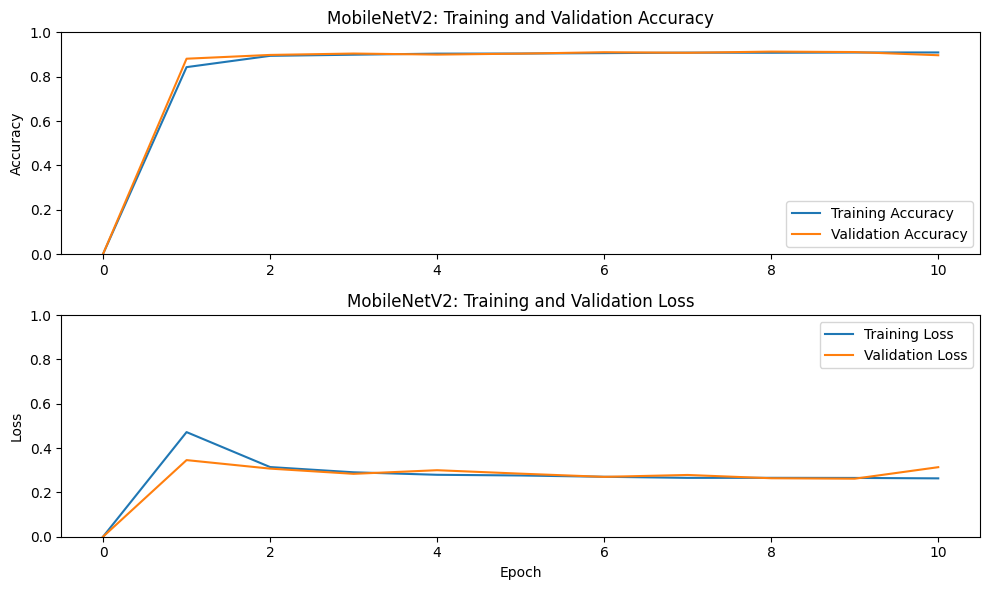

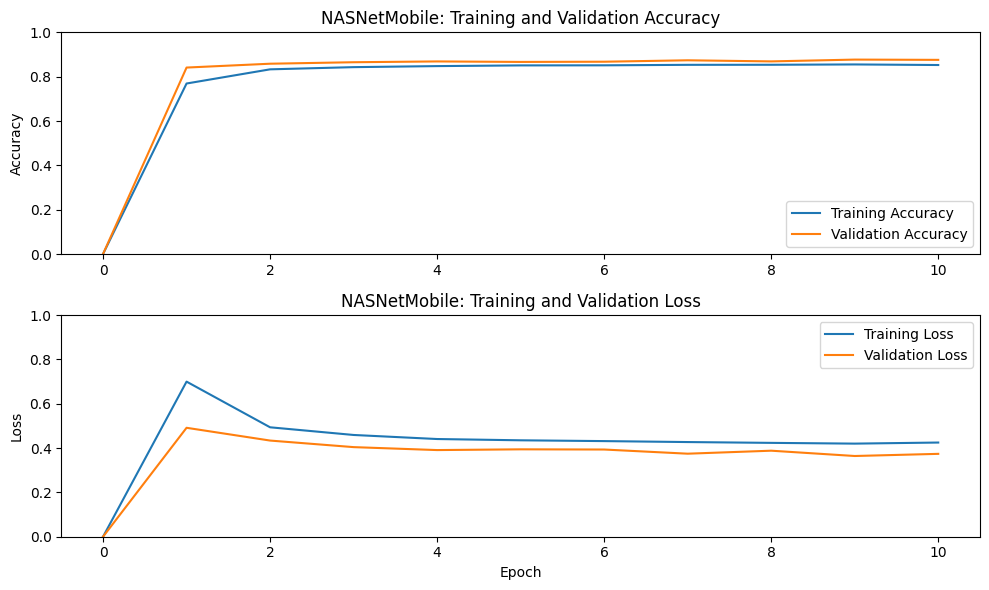

In [35]:
plot_model_history(mobilenetv2_history, "MobileNetV2")
plot_model_history(nasnetmobile_history, "NASNetMobile")


## Confusion Matrix


In [15]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from prettytable import PrettyTable

def evaluate_model(model, test_image_data, model_name="Model"):
    """
    Đánh giá hiệu suất của mô hình trên tập kiểm tra.

    Args:
        model (tf.keras.Model): Mô hình cần đánh giá.
        test_image_data (tf.keras.preprocessing.image.DirectoryIterator): Tập dữ liệu kiểm tra.
        model_name (str): Tên của mô hình (để hiển thị trong kết quả).

    Returns:
        None
    """
    # Dự đoán trên tập kiểm tra
    y_true = []
    y_pred = []

    for x_batch, y_batch in test_image_data:
        y_true.extend(np.argmax(y_batch, axis=1))  # Nhãn thực
        y_pred_probs = model.predict(x_batch)  # Dự đoán xác suất
        y_pred.extend(np.argmax(y_pred_probs, axis=1))  # Nhãn dự đoán

        # Dừng khi đủ số mẫu
        if len(y_true) >= test_image_data.samples:
            break

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Tính các chỉ số hiệu suất
    precision_per_class = precision_score(y_true, y_pred, average=None)
    recall_per_class = recall_score(y_true, y_pred, average=None)
    f1_per_class = f1_score(y_true, y_pred, average=None)

    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_macro = f1_score(y_true, y_pred, average='macro')

    # Tạo bảng hiệu suất
    class_labels = list(test_image_data.class_indices.keys())
    table = PrettyTable()
    table.field_names = ["Class", "Precision", "Recall", "F1 Score"]

    for i, label in enumerate(class_labels):
        table.add_row([label, f"{precision_per_class[i]:.2f}", f"{recall_per_class[i]:.2f}", f"{f1_per_class[i]:.2f}"])

    table.add_row(["Overall", f"{precision_macro:.2f}", f"{recall_macro:.2f}", f"{f1_macro:.2f}"])

    # Hiển thị bảng hiệu suất
    print(f"Results for model: {model_name}")
    print(table)

    # Vẽ ma trận nhầm lẫn
    conf_matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━

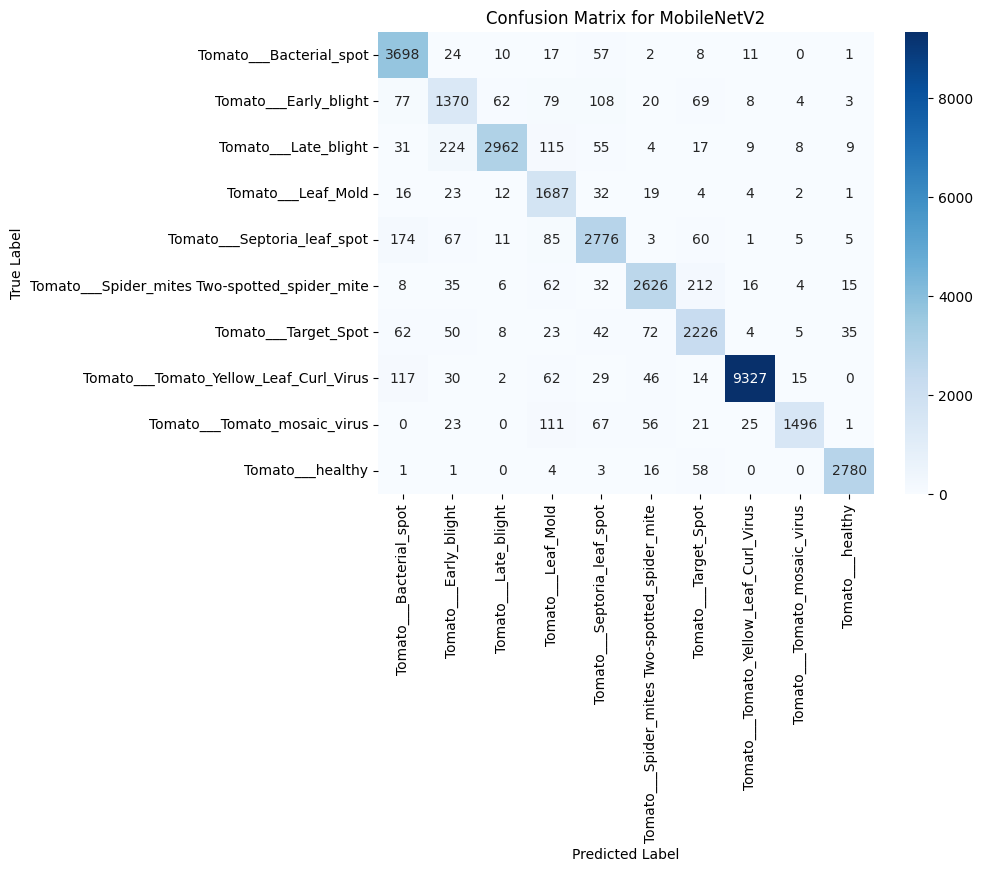

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━

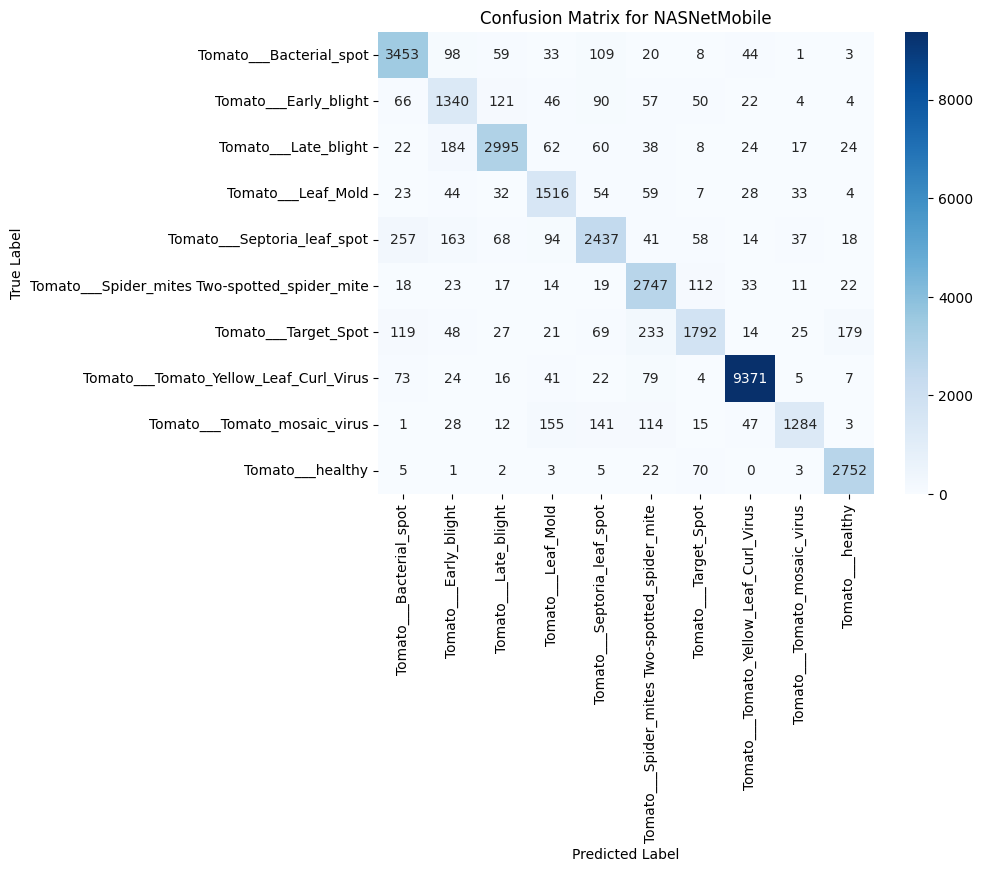

In [17]:
# Đánh giá mô hình MobileNetV2
evaluate_model(mobilenet_model, test_image_data, model_name="MobileNetV2")

# Đánh giá mô hình NASNetMobile
evaluate_model(nasnet_model, test_image_data, model_name="NASNetMobile")

## Save model

In [11]:
mobilenet_model.save('MobileNetV2_PlantVillage_Tomato.keras')
nasnet_model.save('NasNetMobile_PlantVillage_Tomato.keras')


## Quantization and Converting into TensorflowLite


In [19]:
def convert_to_tflite(model_path, output_path):
    """
    Chuyển đổi mô hình Keras sang định dạng TFLite.

    Args:
        model_path (str): Đường dẫn đến mô hình Keras đã lưu (.keras hoặc .h5).
        output_path (str): Đường dẫn để lưu tệp TFLite sau khi chuyển đổi.

    Returns:
        None
    """
    model = tf.keras.models.load_model(model_path)
    print(f"Model loaded successfully from {model_path}")

    converter = tf.lite.TFLiteConverter.from_keras_model(model)

    # Quantization
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    print("Quantization enabled.")

    # Chuyển đổi sang TFLite
    tflite_model = converter.convert()
    print("Model converted to TFLite format successfully.")

    # Lưu mô hình TFLite
    with open(output_path, 'wb') as f:
        f.write(tflite_model)
    print(f"TFLite model saved to {output_path}")


In [21]:
# Chuyển đổi MobileNetV2
convert_to_tflite(
    model_path='/content/MobileNetV2_PlantVillage_Tomato.keras',
    output_path='/content/MobileNetV2_PlantVillage_Tomato.tflite',
)

Model loaded successfully from /content/MobileNetV2_PlantVillage_Tomato.keras
Quantization enabled.
Saved artifact at '/tmp/tmptbj7tumq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  137514577638000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137514577680816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137514577682928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137514577676240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137514577680288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137514577688208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137514577757808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137514577758512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137514577689088: TensorSpec(shape=(), dtype=tf.resou

In [22]:
# Chuyển đổi NASNetMobile
convert_to_tflite(
    model_path='/content/NasNetMobile_PlantVillage_Tomato.keras',
    output_path='/content/NasNetMobile_PlantVillage_Tomato.tflite',
)

Model loaded successfully from /content/NasNetMobile_PlantVillage_Tomato.keras
Quantization enabled.
Saved artifact at '/tmp/tmpjvoy313d'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  137514576845232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137514576853152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137514576806304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137514576848576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137514576850864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137514576849632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137514576815984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137514576817040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137514576814576: TensorSpec(shape=(), dtype=tf.reso

## Check the accuracy after converting into TFLite

In [23]:
def evaluate_tflite_model(interpreter, test_image_data, BATCH_SIZE):
    correct_predictions = 0
    total_predictions = 0
    num_batches_to_test = int(test_image_data.samples / BATCH_SIZE)

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    for batch_idx, (data, labels) in enumerate(test_image_data):
        if batch_idx >= num_batches_to_test:
            break

        for i in range(data.shape[0]):
            single_data = data[i:i+1]
            input_data = single_data.astype(np.float32)

            interpreter.set_tensor(input_details[0]['index'], input_data)
            interpreter.invoke()

            output_data = interpreter.get_tensor(output_details[0]['index'])

            predicted_class = np.argmax(output_data, axis=-1)
            true_class = np.argmax(labels[i])

            # Kiểm tra xem dự đoán có chính xác không
            if predicted_class == true_class:
                correct_predictions += 1
            total_predictions += 1

    # Tính độ chính xác
    accuracy = correct_predictions / total_predictions
    print(f"Accuracy of TFLite model (for {num_batches_to_test} batches): {accuracy * 100:.2f}%")

    return accuracy


In [26]:
# Khởi tạo Interpreter cho MobileNetV2
mobilenet_interpreter = tf.lite.Interpreter(model_path='MobileNetV2_PlantVillage_Tomato.tflite')
mobilenet_interpreter.allocate_tensors()

# Kiểm tra độ chính xác cho MobileNetV2
print("Evaluating MobileNetV2 TFLite model...")
mobilenet_accuracy = evaluate_tflite_model(mobilenet_interpreter, test_image_data, BATCH_SIZE)

Evaluating MobileNetV2 TFLite model...
Accuracy of TFLite model (for 1412 batches): 90.30%


In [25]:
# Khởi tạo Interpreter cho NASNetMobile
nasnet_interpreter = tf.lite.Interpreter(model_path='NasNetMobile_PlantVillage_Tomato.tflite')
nasnet_interpreter.allocate_tensors()
# Kiểm tra độ chính xác cho NASNetMobile
print("Evaluating NASNetMobile TFLite model...")
nasnet_accuracy = evaluate_tflite_model(nasnet_interpreter, test_image_data, BATCH_SIZE)

Evaluating NASNetMobile TFLite model...
Accuracy of TFLite model (for 1412 batches): 87.16%
